In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
import cv2

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [0]:
def load_image(path, size=256):
    im = cv2.imread(path)[:,:,::-1]
    im = (cv2.resize(im, (size, size), interpolation=cv2.INTER_NEAREST) / 255).T
    return torch.FloatTensor(im).unsqueeze(0).to(device)

In [0]:
style = load_image("scream.jpg")
cont  = load_image("lena.jpg")

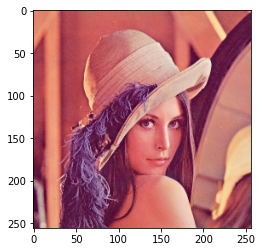

In [119]:
show(cont)

In [0]:
def show(image):
    image = image.squeeze().detach().cpu().numpy().T
    plt.imshow(image)

In [8]:
vgg = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [0]:
class Norm(nn.Module):
    def __init__(self):
        super().__init__()
        self.means = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1).to(device)
        self.stds = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1).to(device)
        
    def forward(self, x):
        return (x - self.means) / self.stds

In [0]:
class model:
    def __init__(self, vgg):
        self.layers = [Norm()] + [vgg for vgg in vgg.modules() if type(vgg) != nn.Sequential]
        
    
    def set_target(self, style, content, style_layers=None, content_layers=None):
        if not style_layers:
            self.style_layers = [0, 1, 2, 3, 4]
        else:
            self.style_layers = style_layers
            
        if not content_layers:
            self.content_layers = [3]
        else:
            self.content_layers = content_layers
            
        self.style_target = {}
        self.content_target = {}
        
        cnt = 0
        xs = style
        xc = content
        for i, layer in enumerate(self.layers):
            xs = layer(xs)
            xc = layer(xc)
            if isinstance(layer, nn.Conv2d):
                if cnt in self.style_layers:
                    self.style_target[cnt] = self.gram(xs).detach()
                    
                if cnt in self.content_layers:
                    self.content_target[cnt] = xc.detach()
                
                cnt += 1
                
            
                
                if cnt > max(self.style_layers) and cnt > max(self.content_layers):
                    break

            if isinstance(layer, nn.ReLU):
                self.layers[i] = nn.ReLU().to(device)
        self.layers = self.layers[:i + 1]
                
                
    def gram(self, x):
        n, c, h, w = x.shape
        f = x.view(n * c, h * w)
        G = torch.mm(f, f.t())
        return G.div(n * c * h * w)
    
    def style_loss(self, x, ind):
        g = self.gram(x)
        return F.mse_loss(g, self.style_target[ind])
        
    def content_loss(self, x, ind):
        return F.mse_loss(x, self.content_target[ind])
        
        
    def train(self, im, steps=100, style_w=1e5, content_w=1):
        opt = optim.LBFGS([im.requires_grad_()])
        
        for ii in range(steps):
            if (ii+1) % 10 == 0:
                print(ii)
            def closure():
                im.data.clamp_(0, 1)
                opt.zero_grad()
                cnt = 0
                x = im.clone()
                sloss = []
                closs = []
                for layer in self.layers:
                    x = layer(x)
                    if isinstance(layer, nn.Conv2d):
                        if cnt in self.style_layers:
                            sloss += [self.style_loss(x, cnt)]

                        if cnt in self.content_layers:
                            closs += [self.content_loss(x, cnt)]

                        cnt += 1
    
                loss = style_w * sum(sloss) + content_w * sum(closs)
                loss.backward()
                return style_w * sum(sloss) + content_w * sum(closs)
            opt.step(closure)
        im.data.clamp_(0, 1)
        return im

In [0]:
a = model(vgg)

In [0]:
a.set_target(style, cont, style_layers=[2, 3, 4], content_layers=[3, 4])

In [0]:
res = cont.clone()

In [168]:
out = a.train(res, 50, 1e6)

9
19
29
39
49


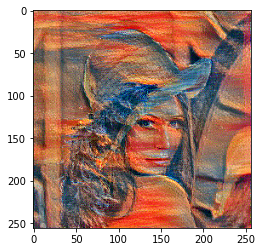

In [169]:
show(out)